## Identifying Latent Return Drivers Using Principal Component Analysis

In [ ]:
!pip install sklearn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from openbb import obb
from sklearn.decomposition import PCA

In [2]:
obb.user.preferences.output_type = "dataframe"

Define the symbols for gold and healthcare stocks

In [3]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

Fetch historical price data for the defined symbols from 2020-01-01 to 2022-12-31 using the "yfinance" provider

In [4]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the daily percentage returns and drop any missing values

In [5]:
returns = data.pct_change().dropna()

Initialize PCA with 3 components and fit it to the returns data

In [6]:
pca = PCA(n_components=3)
pca.fit(returns)

PCA(n_components=3)

Get the explained variance ratio and the principal components

In [7]:
pct = pca.explained_variance_ratio_
pca_components = pca.components_

In [8]:
display(pca_components)

array([[ 0.78402106,  0.06139341,  0.06157203,  0.06678106,  0.29181296,
         0.30862968,  0.42713718,  0.10216529],
       [ 0.03070356,  0.34058264,  0.60677508,  0.39052223, -0.09200527,
        -0.12445024, -0.22896855,  0.53478754],
       [ 0.6180319 , -0.10864359, -0.13197692, -0.07204876, -0.39555206,
        -0.41760383, -0.48391774, -0.13635775]])

Plot the contribution and cumulative contribution of the principal components

In [21]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) + 1, 1)

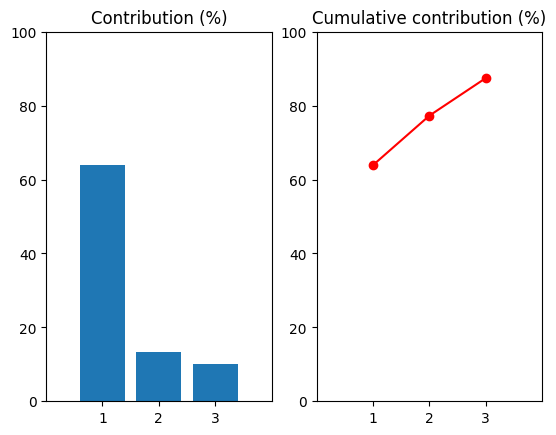

In [22]:
plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, "ro-")
plt.title("Cumulative contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.show()

Construct "statistical risk factors" from the principal components

In [23]:
X = np.asarray(returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], index=returns.index, data=factor_returns
)

In [24]:
display(factor_returns)

,f1,f2,f3
date,,,
2020-01-03,-0.028854,-0.007880,0.013453
2020-01-06,-0.081176,0.006441,-0.058876
2020-01-07,0.003671,-0.015563,-0.013919
2020-01-08,-0.105889,0.028154,-0.005643
2020-01-09,0.001916,0.018522,0.023465
...,...,...,...
2022-12-23,0.001576,0.007398,-0.020952
2022-12-27,0.079420,-0.010218,0.022537
2022-12-28,-0.081093,0.004814,0.005850


Calculate the factor exposures

In [25]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], columns=returns.columns, data=pca_components
).T

In [26]:
display(factor_exposures)

,f1,f2,f3
symbol,,,
CDE,0.784021,0.030704,0.618032
JNJ,0.061393,0.340583,-0.108644
LLY,0.061572,0.606775,-0.131977
MRK,0.066781,0.390522,-0.072049
NEM,0.291813,-0.092005,-0.395552
RGLD,0.308630,-0.124450,-0.417604
SSRM,0.427137,-0.228969,-0.483918
UNH,0.102165,0.534788,-0.136358


Plot the factor exposure of the first principal component

<Axes: xlabel='symbol'>

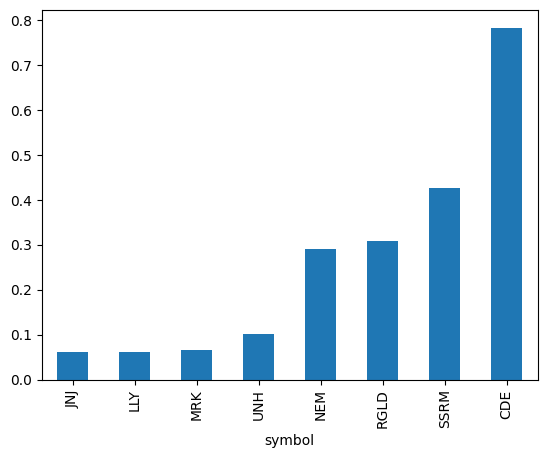

In [27]:
factor_exposures.f1.sort_values().plot.bar()

Scatter plot of the factor exposures of the first two principal components

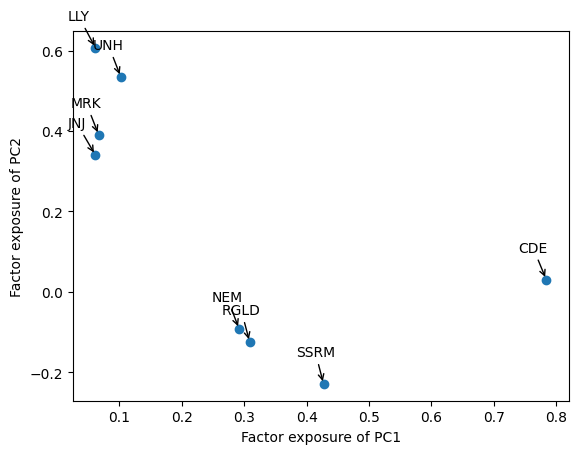

In [31]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("Factor exposure of PC1")
plt.ylabel("Factor exposure of PC2")

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(-20, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
    )

plt.show()

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.

## Finding and Hedging Portfolio Beta Using Linear Regression

In [ ]:
!pip install statsmodels

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression

In [2]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols including the benchmark "SPY"

In [3]:
symbols = [
    "NEM",
    "RGLD",
    "SSRM",
    "CDE",
    "LLY",
    "UNH",
    "JNJ",
    "MRK",
    "SPY",
]

Fetch historical price data for the defined symbols from 2020-01-01 to 2022-12-31 using the "yfinance" provider

In [4]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the daily percentage returns for the benchmark "SPY" and drop any missing values

In [5]:
benchmark_returns = data.pop("SPY").pct_change().dropna()

Calculate the daily percentage returns for the portfolio and drop any missing values

In [6]:
portfolio_returns = data.pct_change().dropna().sum(axis=1)
portfolio_returns.name = "portfolio"

Plot the portfolio and benchmark daily returns

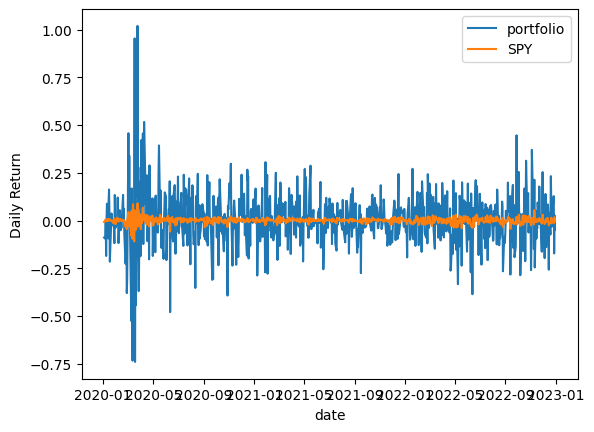

In [7]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()
plt.show()

Define a function for linear regression to calculate alpha and beta

In [8]:
def linreg(x, y):
    # Add a column of 1s to fit alpha

    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done

    x = x[:, 1]
    return model.params[0], model.params[1]

Perform linear regression on the portfolio and benchmark returns to calculate alpha and beta

In [9]:
X = benchmark_returns.values
Y = portfolio_returns.values

In [10]:
alpha, beta = linreg(X, Y)

In [11]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.002638518577761206'

'Beta: 5.55121306008357'

Plot the regression line

In [12]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

Plot the raw data

Text(0, 0.5, 'Portfolio daily return')

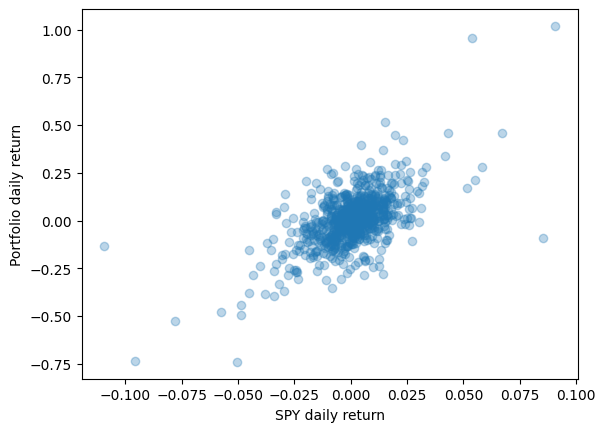

In [13]:
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")

Add the regression line

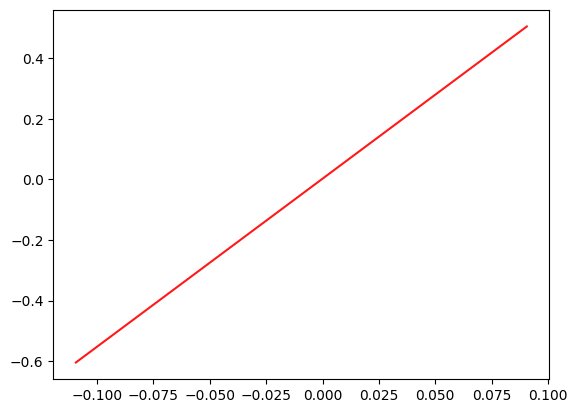

In [14]:
plt.plot(X2, Y_hat, "r", alpha=0.9)
plt.show()

Construct a portfolio with beta hedging

In [15]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

Perform linear regression on the hedged portfolio returns and benchmark returns to calculate alpha and beta

In [16]:
P = hedged_portfolio_returns.values
alpha, beta = linreg(X, P)

In [17]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.0026385185777612072'

'Beta: -5.3398614836742606e-15'

Define a function to calculate the information ratio

In [18]:
def information_ratio(portfolio_returns, benchmark_returns):
    """
    Determines the information ratio of a strategy.

    Parameters
    ----------
    portfolio_returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    benchmark_returns : int, float
        Daily returns of the benchmark or factor, noncumulative.
    Returns
    -------
    information_ratio : float
    Note
    -----
    See https://pyquantnews.com/how-to-measure-skill-portfolio-manager/ for more details.
    """

    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

Calculate the information ratio for the hedged and unhedged portfolios

In [19]:
hedged_ir = information_ratio(hedged_portfolio_returns, benchmark_returns)

In [20]:
unhedged_ir = information_ratio(portfolio_returns, benchmark_returns)

In [21]:
display(f"Hedged information ratio: {hedged_ir}")
display(f"Unhedged information ratio: {unhedged_ir}")

'Hedged information ratio: 0.019857076696277627'

'Unhedged information ratio: 0.030991554126598382'

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.

## Analyzing Portfolio Sensitivities to the Fama-French Factors

In [ ]:
!pip install pandas_datareader

In [1]:
import warnings

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

In [3]:
warnings.filterwarnings("ignore")
obb.user.preferences.output_type = "dataframe"

Define the stock symbols including the benchmark "SPY"

In [4]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK", "SPY"]

Fetch historical price data for the defined symbols from 2015-01-01 to 2022-12-31 using the "yfinance" provider

In [5]:
data = obb.equity.price.historical(
    symbols,
    start_date="2015-01-01",
    end_date="2022-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the monthly percentage returns and convert the index to a monthly period

In [6]:
monthly_returns = data.asfreq("ME").pct_change(fill_method=None).to_period("M")

Separate the benchmark returns from the portfolio returns

In [7]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = (R - bench).dropna()

Fetch the Fama-French factors data

In [8]:
factors = (
    pdr.get_data_famafrench(
        "F-F_Research_Data_Factors",
        start="2015-01-01",
        end="2022-12-31",
    )[0][1:]
    / 100
)
SMB = factors.loc[active.index, "SMB"]
HML = factors.loc[active.index, "HML"]

In [9]:
help(pdr.get_data_famafrench)

Help on function get_data_famafrench in module pandas_datareader.data:

get_data_famafrench(*args, **kwargs)



Create a DataFrame with the active returns and Fama-French factors

In [10]:
df = pd.DataFrame(
    {
        "R": active,
        "SMB": SMB,
        "HML": HML,
    },
    index=active.index,
).dropna()

Perform linear regression to estimate the sensitivities of active returns to the factors

In [11]:
b1, b2 = regression.linear_model.OLS(df.R, df[["SMB", "HML"]]).fit().params

In [12]:
display(f"Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}")

'Sensitivities of active returns to factors:\nSMB: 0.08777022702057138\nHML: -0.026467598838652594'

Perform rolling regression to estimate the time-varying sensitivities

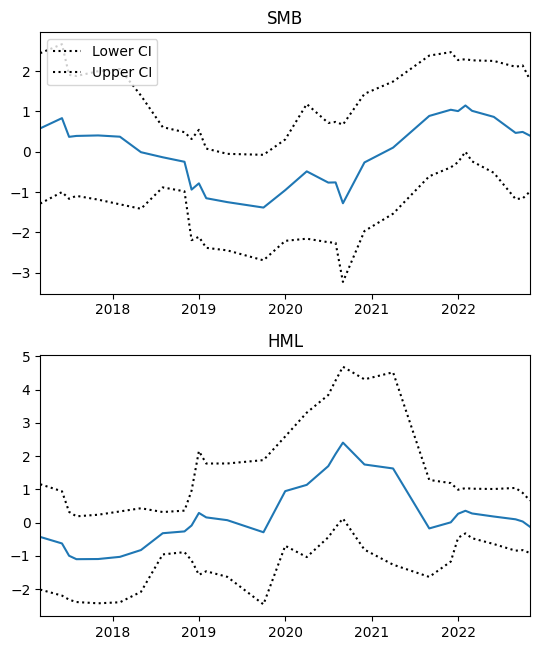

In [13]:
exog = sm.add_constant(df[["SMB", "HML"]])
rols = RollingOLS(active, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=["SMB", "HML"], figsize=(5.5, 6.6))

Estimate the marginal contributions to active risk (MCAR)

In [14]:
F1 = df.SMB
F2 = df.HML
cov = np.cov(F1, F2)
ar_squared = (active.std()) ** 2
mcar1 = (b1 * (b2 * cov[0, 1] + b1 * cov[0, 0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0, 1] + b2 * cov[1, 1])) / ar_squared

In [15]:
display(f"SMB risk contribution: {mcar1}")
display(f"HML risk contribution: {mcar2}")
display(f"Unexplained risk contribution: {1 - (mcar1 + mcar2)}")

'SMB risk contribution: 0.0013761656143921365'

'HML risk contribution: 0.00030080111715510637'

'Unexplained risk contribution: 0.9983230332684527'

Calculate the rolling covariances and active risk squared

In [16]:
covariances = (df[["SMB", "HML"]].rolling(window=12).cov()).dropna()

In [17]:
active_risk_squared = (active.rolling(window=12).std() ** 2).dropna()

Calculate the rolling betas

In [18]:
betas = pd.concat([rres.params.SMB, rres.params.HML], axis=1).dropna()

Create a DataFrame to store the MCAR estimates

In [19]:
MCAR = pd.DataFrame(index=betas.index, columns=betas.columns)

Calculate the MCAR for each factor at each time point

In [20]:
for factor in betas.columns:
    for t in betas.index:
        # Compute the sum of the betas and covariances
        s = np.sum(betas.loc[t] * covariances.loc[t][factor])
        # Get the beta
        b = betas.loc[t][factor]
        # Get active risk squared
        AR = active_risk_squared.loc[t]
        # Put them all together to estimate FMCAR on that date
        MCAR[factor][t] = b * s / AR

Plot the MCAR estimates for each factor

<Axes: xlabel='date'>

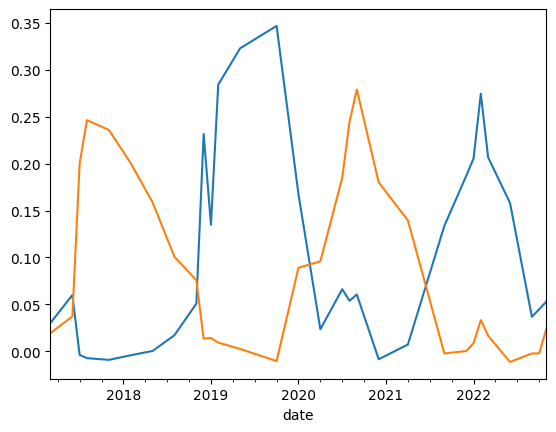

In [21]:
MCAR.SMB.plot()
MCAR.HML.plot()

Plot the unexplained risk contribution

<Axes: xlabel='date'>

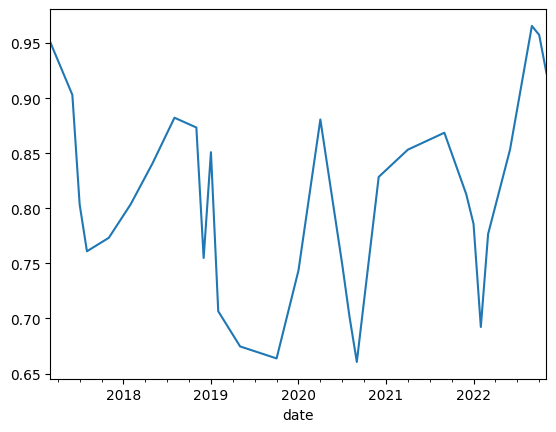

In [22]:
(1 - (MCAR.SMB + MCAR.HML)).plot()

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.

## Assessing Market Inefficiency Based on Volatility

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from openbb import obb
from scipy.stats import spearmanr

In [2]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols

In [3]:
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

Fetch historical price data for the defined symbols from 2015-01-01 to 2022-12-31 using the "yfinance" provider

In [4]:
data = obb.equity.price.historical(
    symbols, start_date="2015-01-01", end_date="2022-12-31", provider="yfinance"
)

Select relevant columns from the data

In [5]:
prices = data[["high", "low", "close", "volume", "symbol"]]

Filter out symbols with less than 2 years of data

In [6]:
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

Reorder levels and sort index

In [7]:
prices = (
    prices.set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

Define a function to calculate Parkinson volatility

In [8]:
def parkinson(data, window=14, trading_days=252):
    rs = (1.0 / (4.0 * np.log(2.0))) * ((data.high / data.low).apply(np.log)) ** 2.0

    def f(v):
        return (trading_days * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    return result.sub(result.mean()).div(result.std())

Calculate volatility using the Parkinson method and add it to the 'prices' DataFrame

In [9]:
prices["vol"] = prices.groupby("symbol", group_keys=False).apply(parkinson)
prices.dropna(inplace=True)

Calculate lagged returns and targets for different time periods

In [10]:
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = prices.groupby(level="symbol").close.pct_change(lag)

In [11]:
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = prices.groupby(level="symbol")[f"return_{t}d"].shift(-t)

In [12]:
display(prices)

high         low       close   volume       vol  \
symbol date                                                                
CDE    2015-01-22    6.430000    6.150000    6.310000  3404900  0.502345   
       2015-01-23    6.250000    5.930000    5.990000  2234000  0.466274   
       2015-01-26    6.130000    5.690000    6.110000  2149800  0.512970   
       2015-01-27    6.420000    6.120000    6.320000  3697700  0.508157   
       2015-01-28    6.360000    5.890000    5.990000  2668300  0.488355   
...                       ...         ...         ...      ...       ...   
UNH    2022-12-23  531.309998  522.900024  531.309998  1292300 -0.477275   
       2022-12-27  535.840027  529.849976  531.989990  1596700 -0.480026   
       2022-12-28  538.150024  527.729980  528.450012  1694200 -0.429139   
       2022-12-29  533.679993  528.859985  529.880005  1379700 -0.450629   
       2022-12-30  530.500000  524.840027  530.179993  1849600 -0.491592   

                   return_1d  return_5d  return_10d  return_21d  return_42d  \
symbol date                                                                   
CDE    2015-01-22        NaN        NaN         NaN         NaN         NaN   
       2015-01-23  -0.050713        NaN         NaN         NaN         NaN   
       2015-01-26   0.020033        NaN         NaN         NaN         NaN   
       2015-01-27   0.034370        NaN         NaN         NaN         NaN   
       2015-01-28  -0.052215        NaN         NaN         NaN         NaN   
...                      ...        ...         ...         ...         ...   
UNH    2022-12-23   0.008006   0.014531   -0.014633    0.003020   -0.016493   
       2022-12-27   0.001280   0.016024   -0.025409   -0.010472   -0.020583   
       2022-12-28  -0.006654   0.015840   -0.018152   -0.007177   -0.024640   
       2022-12-29   0.002706   0.004436   -0.015752    0.003561   -0.038749   
       2022-12-30   0.000566   0.005862    0.004738   -0.032094   -0.044979   

                   return_63d  target_1d  target_5d  target_10d  target_21d  \
symbol date                                                                   
CDE    2015-01-22         NaN  -0.050713  -0.058637    0.145800   -0.083994   
       2015-01-23         NaN   0.020033   0.051753    0.170284   -0.083472   
       2015-01-26         NaN   0.034370   0.045826    0.189853   -0.094926   
       2015-01-27         NaN  -0.052215   0.036392    0.136076   -0.115506   
       2015-01-28         NaN  -0.008347   0.188648    0.158598   -0.025042   
...                       ...        ...        ...         ...         ...   
UNH    2022-12-23    0.045145   0.001280        NaN         NaN         NaN   
       2022-12-27    0.046462  -0.006654        NaN         NaN         NaN   
       2022-12-28    0.028233   0.002706        NaN         NaN         NaN   
       2022-12-29    0.041369   0.000566        NaN         NaN         NaN   
       2022-12-30    0.049778        NaN        NaN         NaN         NaN   

                   target_42d  target_63d  
symbol date                                
CDE    2015-01-22   -0.133122   -0.118859  
       2015-01-23   -0.118531   -0.136895  
       2015-01-26   -0.147300   -0.067103  
       2015-01-27   -0.202532   -0.106013  
       2015-01-28   -0.191987   -0.086811  
...                       ...         ...  
UNH    2022-12-23         NaN         NaN  
       2022-12-27         NaN         NaN  
       2022-12-28         NaN         NaN  
       2022-12-29         NaN         NaN  
       2022-12-30         NaN         NaN  

[16008 rows x 17 columns]

Plot a joint plot of volatility vs. 1-day target return

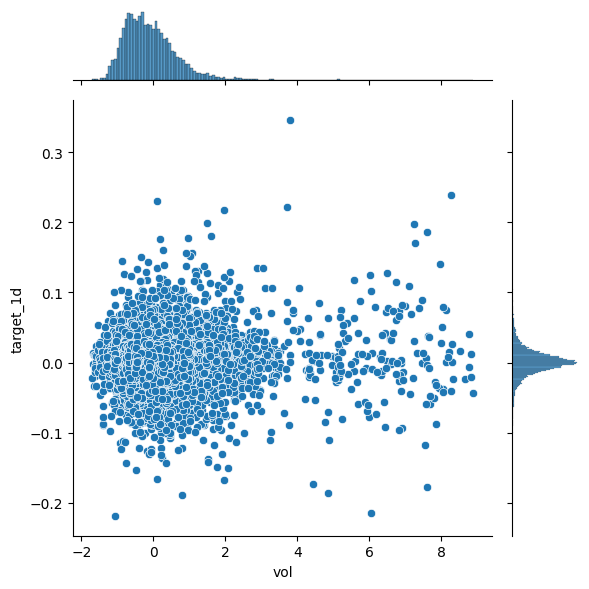

In [13]:
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()

Calculate and display the Spearman rank correlation and p-value

In [14]:
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
display(f"{r:,.2%} ({p:.2%})")

'2.29% (0.38%)'

Display the first 10 rows of 'prices' DataFrame for the symbol "NEM"

In [15]:
d = prices.loc["NEM"].head(10)
display(d)

,high,low,close,volume,vol,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,target_42d,target_63d
date,,,,,,,,,,,,,,,,,
2015-01-22,24.690001,23.980000,24.290001,13132700,1.021514,NaN,NaN,NaN,NaN,NaN,NaN,-0.005764,-0.004940,0.021820,0.068752,-0.058872,-0.034582
2015-01-23,24.430000,23.670000,24.150000,12056800,0.976773,-0.005764,NaN,NaN,NaN,NaN,NaN,0.014079,0.041408,-0.004141,0.068737,-0.069151,0.034369
2015-01-26,24.629999,23.350000,24.490000,11189200,1.059908,0.014079,NaN,NaN,NaN,NaN,NaN,0.026541,0.025316,0.004900,0.063699,-0.095141,0.044916
2015-01-27,25.250000,24.530001,25.139999,10774500,0.948081,0.026541,NaN,NaN,NaN,NaN,NaN,-0.035004,-0.020684,-0.029037,0.046539,-0.115752,0.048131
2015-01-28,25.049999,24.030001,24.260000,11251300,0.962112,-0.035004,NaN,NaN,NaN,NaN,NaN,-0.003710,0.023083,-0.004946,0.085326,-0.092333,0.091509
2015-01-29,24.340000,23.420000,24.170000,8850000,1.016856,-0.003710,-0.004940,NaN,NaN,NaN,NaN,0.040546,0.026893,0.014067,0.071163,-0.101779,0.095987
2015-01-30,25.219999,23.920000,25.150000,11594400,1.139381,0.040546,0.041408,NaN,NaN,NaN,NaN,-0.001590,-0.043738,-0.014712,0.018688,-0.096620,0.053280
2015-02-02,25.200001,24.559999,25.110001,7497000,1.109351,-0.001590,0.025316,NaN,NaN,NaN,NaN,-0.019514,-0.019912,-0.036639,0.003186,-0.110315,0.037435
2015-02-03,25.070000,24.139999,24.620001,9038100,0.957277,-0.019514,-0.020684,NaN,NaN,NaN,NaN,0.008123,-0.008530,0.004874,0.027620,-0.082859,0.054021


Display the metric and target columns

In [16]:
display(df[metric])
display(df[target])

symbol  date      
CDE     2015-01-22    0.502345
        2015-01-23    0.466274
        2015-01-26    0.512970
        2015-01-27    0.508157
        2015-01-28    0.488355
                        ...   
UNH     2022-12-22   -0.464863
        2022-12-23   -0.477275
        2022-12-27   -0.480026
        2022-12-28   -0.429139
        2022-12-29   -0.450629
Name: vol, Length: 16000, dtype: float64

symbol  date      
CDE     2015-01-22   -0.050713
        2015-01-23    0.020033
        2015-01-26    0.034370
        2015-01-27   -0.052215
        2015-01-28   -0.008347
                        ...   
UNH     2022-12-22    0.008006
        2022-12-23    0.001280
        2022-12-27   -0.006654
        2022-12-28    0.002706
        2022-12-29    0.000566
Name: target_1d, Length: 16000, dtype: float64

Display the correlation and p-value

In [17]:
display(r, p)

0.022894821944437795

0.003777781841261211

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.

## Preparing a Factor Ranking Model Using Zipline Pipelines

In [1]:
import os
import warnings

In [6]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from zipline.data import bundles
from zipline.data.bundles.core import load
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import (
    VWAP,
    AnnualizedVolatility,
    AverageDollarVolume,
    BollingerBands,
    CustomFactor,
    DailyReturns,
    ExponentialWeightedMovingAverage,
    MaxDrawdown,
    PercentChange,
    Returns,
    SimpleMovingAverage,
    WeightedAverageValue,
)
from zipline.pipeline.loaders import USEquityPricingLoader

In [7]:
warnings.filterwarnings("ignore")

### Option 1: Use the built-in bundle with free data

This option uses the built-in data bundle provided by Zipline. It then acquires free US equities data that extend through 2018.

In [ ]:
os.environ["QUANDL_API_KEY"] = "YOUR_API_KEY"
bundle = "quandl"
bundles.ingest(bundle)

### Option 2: Use the custom bundle with premium data

This option uses the custom bundle with premium data. Follow the steps here: https://pyquantnews.com/ingest-premium-market-data-with-zipline-reloaded/ before using.

In [ ]:
os.environ["DATALINK_API_KEY"] = "YOUR_API_KEY"
bundle = "quotemedia"
load_extensions(True, [], False, os.environ)
bundles.ingest(bundle)

Ingest the bundle data from your selected bundle.

In [9]:
bundle_data = load(bundle, os.environ, None)

Create a USEquityPricingLoader

In [10]:
pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader, fx_reader=None
)

Initialize a SimplePipelineEngine

In [11]:
engine = SimplePipelineEngine(
    get_loader=lambda col: pipeline_loader, asset_finder=bundle_data.asset_finder
)

Define a custom momentum factor

In [12]:
class MomentumFactor(CustomFactor):
    """Momentum factor"""

    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252

    def compute(self, today, assets, out, prices, returns):
        out[:] = (
            (prices[-21] - prices[-252]) / prices[-252]
            - (prices[-1] - prices[-21]) / prices[-21]
        ) / np.nanstd(returns, axis=0)

Define a function to create a pipeline

In [13]:
def make_pipeline():
    momentum = MomentumFactor()
    dollar_volume = AverageDollarVolume(window_length=30)

    return Pipeline(
        columns={
            "factor": momentum,
            "longs": momentum.top(50),
            "shorts": momentum.bottom(50),
            "rank": momentum.rank(),
        },
        screen=dollar_volume.top(100),
    )

Run the pipeline

In [14]:
results = engine.run_pipeline(
    make_pipeline(), pd.to_datetime("2012-01-04"), pd.to_datetime("2012-03-01")
)

Clean and display the results

In [15]:
results.dropna(subset="factor", inplace=True)
results.index.names = ["date", "symbol"]
results.sort_values(by=["date", "factor"], inplace=True)

In [16]:
display(results)

factor  longs  shorts    rank
date       symbol                                              
2012-01-04 Equity(300 [BAC])   -2.522045  False   False   165.0
           Equity(1264 [GS])   -2.215784  False   False   220.0
           Equity(1888 [MS])   -2.204802  False   False   225.0
           Equity(1894 [MSFT]) -1.949654  False   False   295.0
           Equity(457 [C])     -1.830819  False   False   345.0
...                                  ...    ...     ...     ...
2012-03-01 Equity(3105 [WMT])   3.409414  False   False  2607.0
           Equity(1690 [LLY])   3.809608  False   False  2642.0
           Equity(399 [BMY])    4.689588   True   False  2685.0
           Equity(1770 [MCD])   4.816880   True   False  2691.0
           Equity(1789 [MDLZ])  5.680276   True   False  2706.0

[4000 rows x 4 columns]

**Jason Strimpel** is the founder of <a href='https://pyquantnews.com/'>PyQuant News</a> and co-founder of <a href='https://www.tradeblotter.io/'>Trade Blotter</a>. His career in algorithmic trading spans 20+ years. He previously traded for a Chicago-based hedge fund, was a risk manager at JPMorgan, and managed production risk technology for an energy derivatives trading firm in London. In Singapore, he served as APAC CIO for an agricultural trading firm and built the data science team for a global metals trading firm. Jason holds degrees in Finance and Economics and a Master's in Quantitative Finance from the Illinois Institute of Technology. His career spans America, Europe, and Asia. He shares his expertise through the <a href='https://pyquantnews.com/subscribe-to-the-pyquant-newsletter/'>PyQuant Newsletter</a>, social media, and has taught over 1,000+ algorithmic trading with Python in his popular course **<a href='https://gettingstartedwithpythonforquantfinance.com/'>Getting Started With Python for Quant Finance</a>**. All code is for educational purposes only. Nothing provided here is financial advise. Use at your own risk.